In [1]:
tuple([0,1])

(0, 1)

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ioff()
from skimage import io
from skimage.draw import disk, circle_perimeter
import pandas as pd
import numpy as np
from os import path
import datetime

In [2]:
import sys
sys.path.append("/home/ula/ext/pyxfiles/")  
import importlib
import shuffle_row
importlib.reload(shuffle_row)
import numpy as np

In [3]:
base_path = "/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/"
res_dir_path = base_path + "alignment_result/"
dir_path = res_dir_path + "aligned_despeckle/"
cell_data_fn_template = "m{}r{}_{}_output.txt"
img_fn_template = "m{}r{}_{}.tif"
excel_path = "/home/ula/twophoton/summary.xlsx"
excel_sheet_name = "summary"


In [4]:
all_rois = np.array([(1,1,'l'), (1,2,'l'), 
                    (2,1,'c'), (2,2,'c'), 
                    (3,1,'l'), (3,2,'l'), 
                    (4,1,'l'), (4,2,'l'), 
                    (5,1,'c'), (5,2,'c'), (5,3,'c'), 
                    (6,1,'l'), (6,2,'l'), 
                    (7,1,'l'), (7,2,'l'), (7,3,'l'), 
                    (8,1,'c'), (8,2,'c'), 
                    #(9,1,'l'), (9,2,'l'),
                   (10,1,'c'), (10,2,'c'), (10,3,'c'), 
                    (11,1,'c'), (11,2,'c'), (11,3,'c'), 
                    (12,1,'l'), (12,2,'l'), (12,3,'l'),
                   (13,1,'c'), (13,2,'c'), (13,3,'c'),
                   (14,1,'c'), (14,2,'c'), (14,3,'c'), (14,4,'c'),
                   (15,1,'l'), (15,2,'l'), (15,3,'l'),
                   (16,1,'c'), (16,2,'c'),
                   (17,1,'l'), (17,2,'l'),
                   (18,1,'l'), (18,2,'l'),
                   #(19,1,'c'), (19,2,'c'),
                   (20,1,'c'), (20,2,'c'), (20,3,'c')
])

In [5]:
def add_to_means_dict(df, code, column_pair, pair_code, res_dict, weights=None):

    if weights == None:
        weights = [1]*df.shape[0]
    common_cond = (df.code==code)
    column_cond = (df[column_pair[0]]>0) | (df[column_pair[1]]>0)
    calculated_mean = np.average((abs(df[column_pair[1]]
                                   -df[column_pair[0]]))[common_cond&column_cond],
                                weights=1/(np.array(weights))[common_cond&column_cond])
    res_dict[code+pair_code] = np.append(res_dict[code+pair_code], calculated_mean)

In [6]:
def rewrite_background(df, cols,  q, value = 0):
    for col in cols:
        df.iloc[df[col]<(df[col][df[col]>0]).quantile(q)] = value
    return df

In [7]:
def filter_by_quantiles(df, q):
    condition = [False]*df.shape[0]
    for i in range(3):
        quantiles.append(df[df['i'+str(i)]>0]['i'+str(i)].quantile(q))
        condition = condition | (df['i'+str(i)] > quantiles[i])
    max_bgr = max(quantiles)
    df = df[condition]
    df = df.loc[((abs(df.max(axis=1) - df.min(axis=1))>max_bgr)
                 |(df.i0<quantiles[0])|(df.i1<quantiles[1])|(df.i2<quantiles[2]))]
    df = rewrite_background(df, ["i0", "i1", "i2"],  q)
    #dodac unchanging cells
    return df

In [8]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [10]:
print(datetime.datetime.now())
cols = ['i0', 'i1', 'i2']
iters = 1000
q=0

unshuffled_dfs = []
randomized_dfs = []
idx_keys = []
quantiles = []


roi_idx = 0      
for m, r, code in all_rois:
    ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
    ord_cells = ord_cells
    ord_cells['code'] = [code]*ord_cells.shape[0]
    unshuffled_dfs.append(ord_cells)
unshuffled_dfs = pd.concat(unshuffled_dfs, axis = 0, keys = range(all_rois.shape[0]))
        

for j in range(1):#all_rois.shape[0]):
    code = all_rois[j][-1]
    
    res_dict = {'ldiff':np.array([]),
           'cdiff':np.array([]),
           'lsame':np.array([]),
           'csame':np.array([])}


    for i in range(iters):
        weights = []
        df_to_shuffle = unshuffled_dfs.loc[j]
        if i > 0:
            res0, res1, res2 = shuffle_row.apply_shuffle_row(np.array(df_to_shuffle.i0),
                                      np.array(df_to_shuffle.i1),
                                      np.array(df_to_shuffle.i2))
            df_to_shuffle.i0 = res0
            df_to_shuffle.i1 = res1
            df_to_shuffle.i2 = res2
        df_to_shuffle = filter_by_quantiles(df_to_shuffle, q)
        weights.extend([df_to_shuffle.shape[0]]*df_to_shuffle.shape[0])
        add_to_means_dict(df_to_shuffle, code, ["i0", "i1"], "diff", res_dict)
        add_to_means_dict(df_to_shuffle, code, ["i1", "i2"], "same", res_dict)
    key=code+'diff'
    plt.hist(res_dict[key][1:], bins = 20, label="diff")
    plt.axvline(res_dict[key][0], color='red', label="diff")
    key=code+'same'
    plt.hist(res_dict[key][1:], bins = 20, label="same", alpha=0.5)
    plt.axvline(res_dict[key][0], color='green', label="same")
    plt.title(str(all_rois[j])+" q  = "+str(q)+" iters  = "+str(iters))
    #plt.xlim(0.49, 0.57)
    plt.legend()
    plt.show()


2022-11-02 14:33:16.981888


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


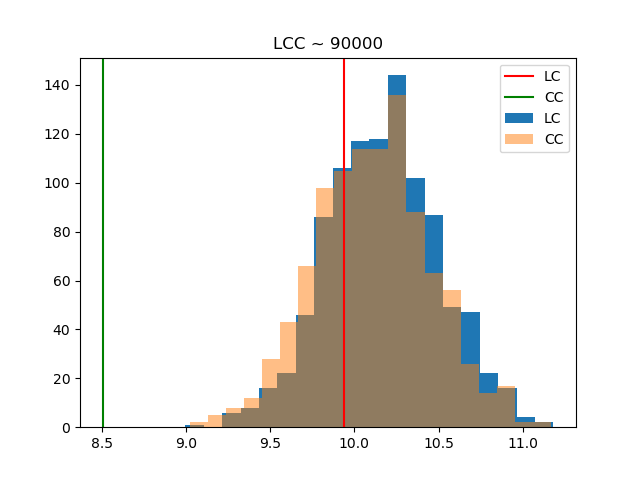

In [10]:
    '''
    key='cdiff'
    plt.hist(res_dict[key][1:], bins = 20, label="CL")
    plt.axvline(res_dict[key][0], color='red', label="CL")
    plt.title("CLL")
    #plt.xlim(0.49, 0.57)
    key = 'csame'
    plt.hist(res_dict[key][1:], bins = 20, label="LL", alpha=0.5)#, range = (11,12.7))
    plt.axvline(res_dict[key][0], color='green', label="LL")
    plt.legend()
    plt.show()
'''
    key='ldiff'
    plt.hist(res_dict[key][1:], bins = 20, label="LC")
    plt.axvline(res_dict[key][0], color='red', label="LC")
    plt.title("LCC ~ 90000")
    #plt.xlim(0.49, 0.57)
    key = 'lsame'
    plt.hist(res_dict[key][1:], bins = 20, label="CC", alpha=0.5)#, range = (11,12.7))
    plt.axvline(res_dict[key][0], color='green', label="CC")
    plt.legend()
    plt.show()
    

In [11]:
print(datetime.datetime.now())
cols = ['i0', 'i1', 'i2']
iters = 50000
q=0

unshuffled_dfs = []
randomized_dfs = []
idx_keys = []
quantiles = []

res_dict = {'ldiff':np.array([]),
           'cdiff':np.array([]),
           'lsame':np.array([]),
           'csame':np.array([])}
roi_idx = 0      
for m, r, code in [(10,1,'c')]:
    ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
    ord_cells = ord_cells[(ord_cells.i0>0)|(ord_cells.i1>0)]
    
    
    ord_cells = ord_cells[(abs(ord_cells.i0-ord_cells.i1)>20)|(ord_cells[['i0', 'i1']].mean(axis=1)>40)]
    ord_cells = ord_cells.sample(n=100, axis=0)
    ord_cells['code'] = [code]*ord_cells.shape[0]
    #ord_cells = filter_by_quantiles(ord_cells, q)
    unshuffled_dfs.append(ord_cells)
unshuffled_dfs = pd.concat(unshuffled_dfs, axis = 0, keys = range(1))#all_rois.shape[0]))
        
for i in range(iters):
    summary_df = pd.DataFrame()
    weights = []
    for j in range(1):#all_rois.shape[0]):
        df_to_shuffle = unshuffled_dfs.loc[j]
        if i > 0:
            res = np.array(df_to_shuffle.i1)
            np.random.shuffle(res)
            df_to_shuffle.i1 = res
        weights.extend([df_to_shuffle.shape[0]]*df_to_shuffle.shape[0])
        summary_df = pd.concat([summary_df, df_to_shuffle])

    for code in ['c']:
        add_to_means_dict(summary_df, code, ["i0", "i1"], "diff", res_dict)#,weights)
        add_to_means_dict(summary_df, code, ["i1", "i2"], "same", res_dict)#,weights)

    if i%10000==0:
        print(i)
print(datetime.datetime.now())

2022-11-02 14:33:48.012354
0
10000
20000
30000
40000
2022-11-02 14:36:16.189889


<IPython.core.display.Javascript object>


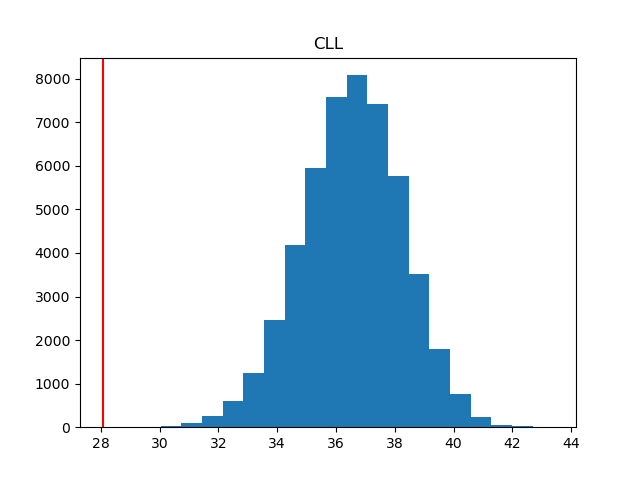

'\nkey = \'csame\'\nplt.hist(res_dict[key][1:], bins = 20, label="LL", alpha=0.5)#, range = (11,12.7))\nplt.axvline(res_dict[key][0], color=\'green\', label="LL")\nplt.legend()\nplt.show()\n\nkey=\'ldiff\'\nplt.hist(res_dict[key][1:], bins = 20, label="LC")\nplt.axvline(res_dict[key][0], color=\'red\', label="LC")\nplt.title("LCC")\n#plt.xlim(0.49, 0.57)\nkey = \'lsame\'\nplt.hist(res_dict[key][1:], bins = 20, label="CC", alpha=0.5)#, range = (11,12.7))\nplt.axvline(res_dict[key][0], color=\'green\', label="CC")\nplt.legend()\nplt.show()\n'

In [12]:
    key='cdiff'
    plt.hist(res_dict[key][1:], bins = 20, label="CL")
    plt.axvline(res_dict[key][0], color='red', label="CL")
    plt.title("CLL")
    #plt.xlim(0.49, 0.57)
    plt.show()
'''
    key = 'csame'
    plt.hist(res_dict[key][1:], bins = 20, label="LL", alpha=0.5)#, range = (11,12.7))
    plt.axvline(res_dict[key][0], color='green', label="LL")
    plt.legend()
    plt.show()

    key='ldiff'
    plt.hist(res_dict[key][1:], bins = 20, label="LC")
    plt.axvline(res_dict[key][0], color='red', label="LC")
    plt.title("LCC")
    #plt.xlim(0.49, 0.57)
    key = 'lsame'
    plt.hist(res_dict[key][1:], bins = 20, label="CC", alpha=0.5)#, range = (11,12.7))
    plt.axvline(res_dict[key][0], color='green', label="CC")
    plt.legend()
    plt.show()
'''

17.284228234475577


<IPython.core.display.Javascript object>


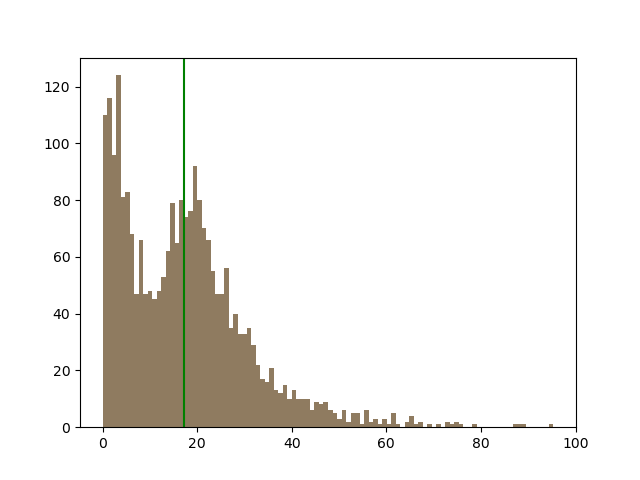

In [53]:
for m, r, code in [(8,1,'c')]:
    ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
    #ord_cells = ord_cells[(abs(ord_cells.i0-ord_cells.i1)>20)|(ord_cells[['i0', 'i1']].mean(axis=1)>40)]
    
    df_diff = ord_cells[(ord_cells.i0>0) |(ord_cells.i1>0)]
    df_diff["abs_d"] = abs(df_diff.i0-df_diff.i1)
    df_diff["abs_d2"] = abs(df_diff.i1-df_diff.i2)
    df_diff["mean_d"] = df_diff[['i0', 'i1']].mean(axis=1)
    df_diff["mean_d2"] = df_diff[['i0', 'i1']].mean(axis=1)
    #df_diff = df_diff.sample(n=100, axis=0)
    
    plt.hist(abs(df_diff.i0-df_diff.i1), bins = 100)
    plt.axvline(np.mean(abs(df_diff.i0-df_diff.i1)), color='green')
    print(np.mean(abs(df_diff.i0-df_diff.i1)))
    #df_diff = df_diff[(df_diff.abs_d>20 )|(2*df_diff.mean_d>50)]
    plt.hist(abs(df_diff.i0-df_diff.i1), bins = 100, alpha=0.5)
    #res = np.array(ord_cells.i1)
    #np.random.shuffle(res)
    #ord_cells.i1 = res
    #df_diff = ord_cells[(ord_cells.i0>0) |(ord_cells.i1>0)]
    #plt.hist(abs(df_diff.i0-df_diff.i1), bins = 100, alpha=0.5)
    #print(np.mean(abs(df_diff.i0-df_diff.i1)))
    #
    #plt.axvline(np.mean(abs(df_diff.i0-df_diff.i1)), color='red', label="shuffled")
    plt.show()

<ipython-input-49-42fb7f0657f2>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  notin3 = atl_one[(df_diff.i2==0)]


<IPython.core.display.Javascript object>


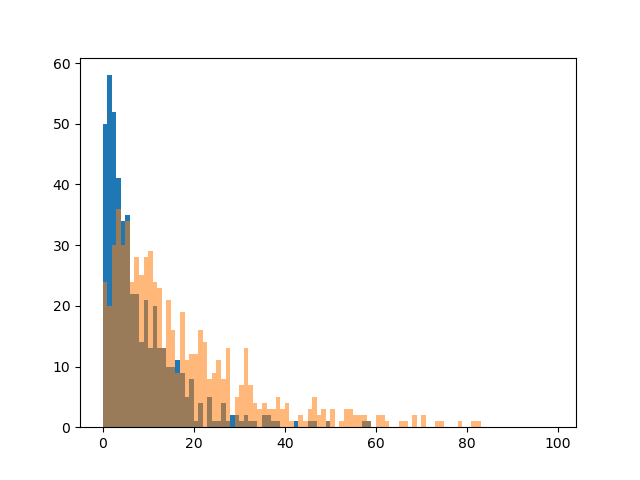

In [49]:
ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))

df_diff = ord_cells[(ord_cells.i0>0) |(ord_cells.i1>0)]
df_diff["abs_d"] = abs(df_diff.i0-df_diff.i1)
atl_one = df_diff[(df_diff.i0>0)|(df_diff.i1>0)]
both = df_diff[(df_diff.i0>0)&(df_diff.i1>0)]
notin3 = atl_one[(df_diff.i2==0)]
both_only = df_diff[(df_diff.i0>0)&(df_diff.i1>0)&(df_diff.i2==0)]
bins_d = np.arange(100)
plt.hist(both_only.abs_d, bins=bins_d)
'''
plt.hist(both.abs_d, bins=bins_d, alpha=0.55)
plt.hist(atl_one.abs_d, bins=bins_d)
plt.hist(both_only.abs_d, alpha=0.5, bins=bins_d)
'''


res = np.array(df_diff.i1)
np.random.shuffle(res)
df_diff.i1 = res
df_diff["abs_d"] = abs(df_diff.i0-df_diff.i1)
df_diff["abs_d2"] = abs(df_diff.i1-df_diff.i2)
atl_one = df_diff[(df_diff.i0>0)|(df_diff.i1>0)]
both = df_diff[(df_diff.i0>0)&(df_diff.i1>0)]
notin3 = atl_one[(df_diff.i2==0)]
both_only = df_diff[(df_diff.i0>0)&(df_diff.i1>0)&(df_diff.i2==0)]

plt.hist(both_only.abs_d, bins=bins_d, alpha=0.55)
'''
plt.hist(both.abs_d, bins=bins_d, alpha=0.55)
plt.hist(atl_one.abs_d, bins=bins_d)
plt.hist(both_only.abs_d, alpha=0.5, bins=bins_d)
'''
plt.show()


<IPython.core.display.Javascript object>


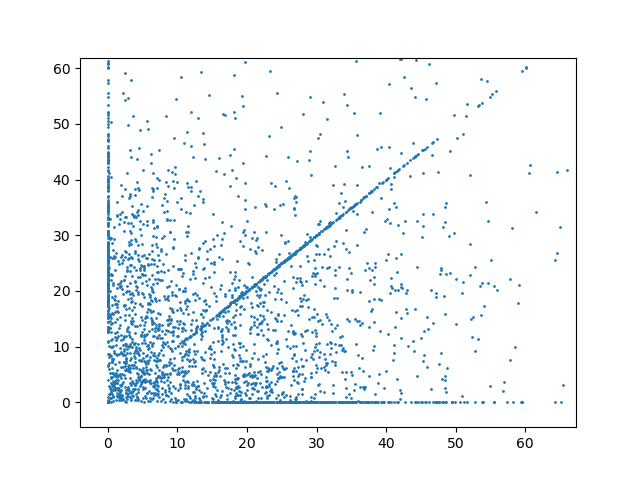

In [20]:
ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
ord_cells["abs_d"] = abs(ord_cells.i0-ord_cells.i1)
ord_cells["abs_d2"] = abs(ord_cells.i1-ord_cells.i2)
ord_cells["mean_d"] = ord_cells[['i0', 'i1']].mean(axis=1)
ord_cells["mean_d2"] = ord_cells[['i1', 'i2']].mean(axis=1)
df_diff1 = ord_cells[(ord_cells.i0>0) |(ord_cells.i1>0)]
df_diff2 = ord_cells[(ord_cells.i1>0) |(ord_cells.i2>0)]


#ax = fig.add_subplot(projection='3d')

#ax.set_xlabel('diff')
#ax.set_ylabel('i0')
#ax.set_zlabel('i1')
#plt.scatter(abs(df_same.i1-df_same.i2), df_same[['i1', 'i2']].max(axis=1), s=1, alpha=0.5)
plt.scatter(ord_cells.abs_d, ord_cells.abs_d2, s=1)#,colormap='plasma')
plt.show()

In [16]:
print(datetime.datetime.now())
a,b,c = shuffle_row.apply_shuffle_row(np.array(unshuffled_dfs.i0),
                              np.array(unshuffled_dfs.i1),
                              np.array(unshuffled_dfs.i2))
unshuffled_dfs.i0 = a
unshuffled_dfs.i1 = b
unshuffled_dfs.i2 = c
print(datetime.datetime.now())

2022-10-25 15:09:38.751144
2022-10-25 15:09:38.752758


In [17]:
print(datetime.datetime.now())
unshuffled_dfs.apply(np.random.shuffle, axis=1)
print(datetime.datetime.now())

2022-10-25 15:09:38.757210
2022-10-25 15:09:38.779176


In [18]:
tst = np.append(unshuffled_dfs.i0,[unshuffled_dfs.i1,unshuffled_dfs.i2])

<IPython.core.display.Javascript object>


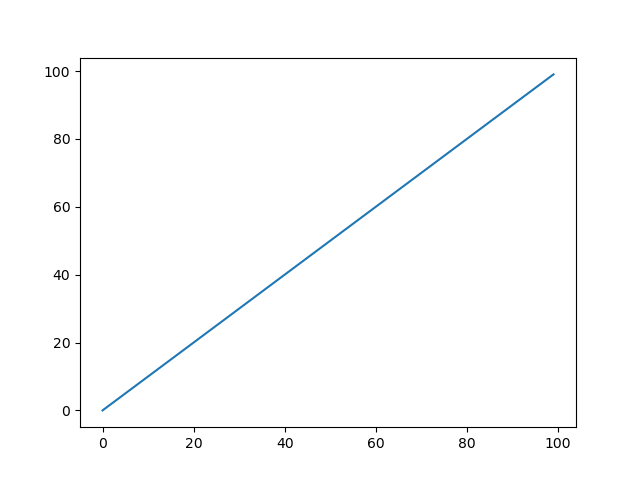

In [19]:
plt.plot(np.arange(100))
plt.show()

In [20]:
res_dict

{'ldiff': array([], dtype=float64),
 'cdiff': array([28.0619761 , 37.70592449, 33.77437097, ..., 39.32746405,
        37.88754703, 38.35818804]),
 'lsame': array([], dtype=float64),
 'csame': array([21.65595011, 36.36841373, 33.70285557, ..., 36.65016892,
        36.32977799, 37.36035437])}

In [21]:
1/np.unique(np.array(weights))

array([0.01])